<h1>Simple Amplitude Adder</h1>

In [1]:
# kernel extension for conditional cell execution
#
# set skip to True (%%skip True) in any block you want to skip

%reload_ext skip_extension

<h2>Step 0. Obtain the API_KEY from the .env file</h2>

In [2]:
from environs import Env
from IPython.display import display, Markdown

env = Env()

#env.read_env()                         # this does not work (?)
env.read_env('.env', recurse=False)     # read .env file, if it exists

token = env('IBM_QUANTUM_TOKEN')  

display(Markdown('<span style="color:red">>>> Token: ' + token[:5] + '...</span>'))     # Check that the starting characters of the token are printed

<span style="color:red">>>> Token: 4a7ea...</span>

<h2>Step 1.1. Create a simple adder circuit</h2>

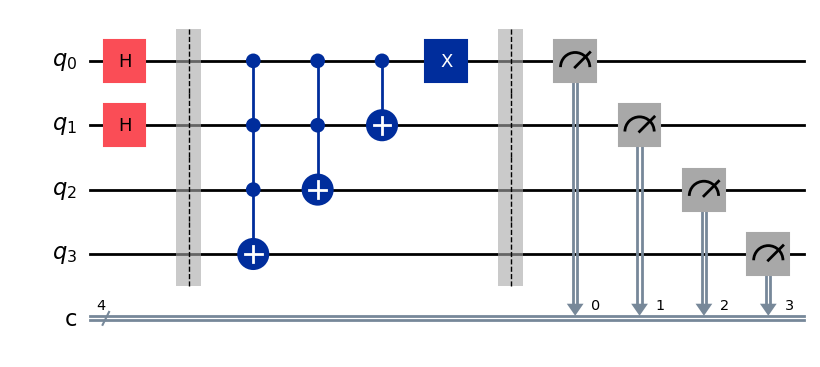

In [9]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit.library import C3XGate

qreg_q = QuantumRegister(4, 'q')
creg_c = ClassicalRegister(4, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

# Input: qubits 0 and 1 in superposition
circuit.h(qreg_q[0])
circuit.h(qreg_q[1])
# circuit.h(qreg_q[2])
# circuit.h(qreg_q[3])

# Alternative input: 0110 (6)
# circuit.x(qreg_q[1])
# circuit.x(qreg_q[2])

circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2], qreg_q[3])

circuit.append(C3XGate(), [qreg_q[0], qreg_q[1], qreg_q[2], qreg_q[3]])
circuit.ccx(qreg_q[0], qreg_q[1], qreg_q[2])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.x(qreg_q[0])

circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2], qreg_q[3])

circuit.measure(qreg_q[0], creg_c[0])
circuit.measure(qreg_q[1], creg_c[1])
circuit.measure(qreg_q[2], creg_c[2])
circuit.measure(qreg_q[3], creg_c[3])

# Return a drawing of the circuit using MatPlotLib ("mpl"). This is the
# last line of the cell, so the drawing appears in the cell output.
# Remove the "mpl" argument to get a text drawing.
circuit.draw("mpl")

<h2>Step 2.1.a. Set up backend for simulation</h2>

In [6]:
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2

backend = FakeAlmadenV2()

<h2>Step 2.1.b. Alternatively set up backend for hardware QPU</h2>

In [3]:
%%skip False      # set to True/False in order to skip/run this cell

display(Markdown('## <span style="color:red">>>>WARNING: *** No simulation. Next steps will run the circuit on hardware QPU ***</span>'))

from qiskit_ibm_runtime import QiskitRuntimeService

# If you did not previously save your credentials, use the following line instead:
# service = QiskitRuntimeService(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>")
service = QiskitRuntimeService(channel="ibm_quantum", token=token)

backend = service.least_busy(simulator=False, operational=True)

## <span style="color:red">>>>WARNING: *** No simulation. Next steps will run the circuit on hardware QPU ***</span>

<h2>Step 2.2. Convert to an ISA circuit layout</h2> 
<h3>(either for simulation or running on hardware QPU)</h3>

<span style="color:red">>>> Execution backend: ibm_brisbane</span>

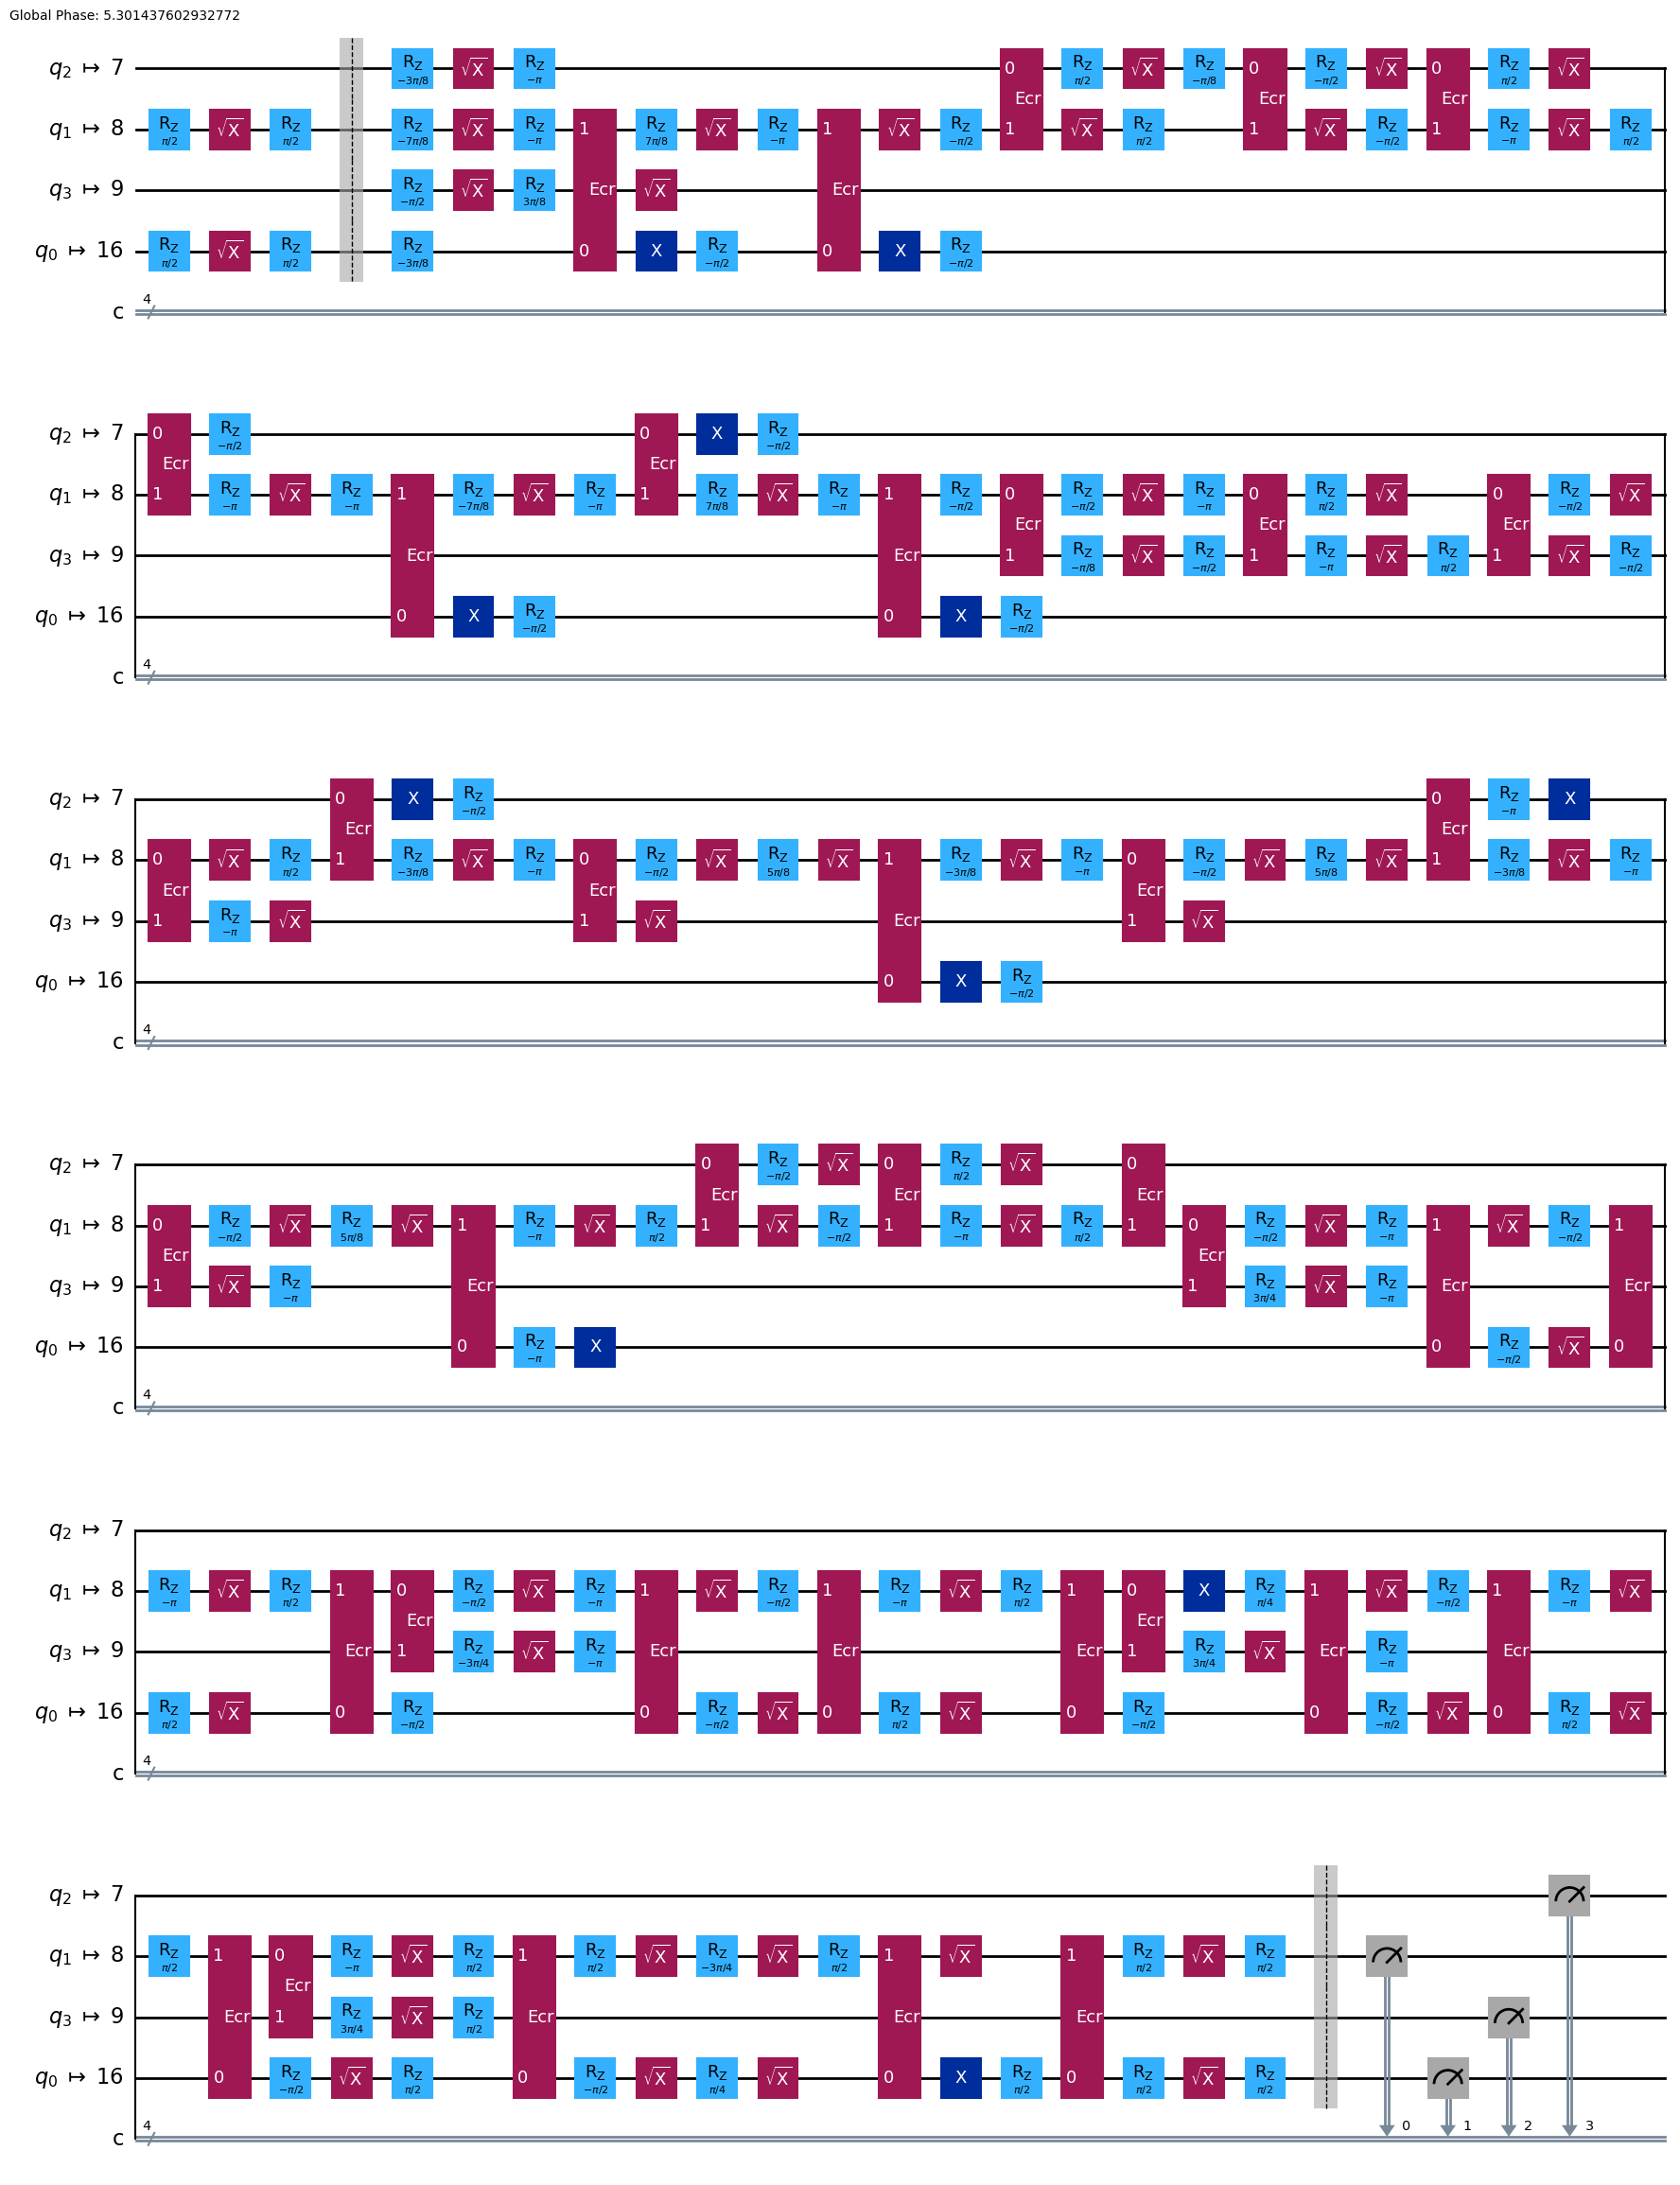

In [11]:
# Convert to an ISA circuit layout

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

display(Markdown('<span style="color:red">>>> Execution backend: ' + backend.name + '</span>'))

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(circuit)

isa_circuit.draw('mpl', idle_wires=False)


<h2>Step 3.a. Simulate the circuit</h2>

In [10]:

job = backend.run([isa_circuit], shots=1000)

# backend run deprecated. Substitute by:
# (but it didn't work properly for simulation, only for QPU execution)
# from qiskit_ibm_runtime import SamplerV2 as Sampler
# sampler = Sampler(mode=backend)
# job = sampler.run([isa_circuit],shots=1000)

# Use the job ID to retrieve your job data later

job_id = job.job_id()

display(Markdown('<span style="color:red">>>> Save the job id for accessing the results when finished:<br>' +
                                         '>>> Job ID: ' + job_id + ' (' + str(job.status()) + ')</span>' ))


<span style="color:red">>>> Save the job id for accessing the results when finished:<br>>>> Job ID: e7828540-9595-4a89-a4a3-a2c30b5b07da (JobStatus.RUNNING)</span>

<h2>Step 3.b. Run the circuit on hardware QPU</h2>

In [12]:
%%skip False      # set to True/False in order to skip/run this cell

# job = backend.run([isa_circuit], shots=5000)
# backend run deprecated. Substitute by:

from qiskit_ibm_runtime import SamplerV2 as Sampler
sampler = Sampler(mode=backend)
job = sampler.run([isa_circuit],shots=1000)

# Use the job ID to retrieve your job data later

job_id = job.job_id()

display(Markdown('<span style="color:red">>>> Save the job id for accessing the results when finished:<br>' +
                                         '>>> Job ID: ' + job_id + ' (' + str(job.status()) + ')</span>' ))


<span style="color:red">>>> Save the job id for accessing the results when finished:<br>>>> Job ID: cwhwybhmptp0008k561g (QUEUED)</span>

<h2>Step 4.1'.a. Access the results</h2>
<h3> (only for simulation)</h3>

In [12]:

# In order to fully recover your Job object, you need the job id.
# When the job is done, you can recover the Job object like this:

# Job for which we are showing the results.

display(Markdown('<span style="color:red">>>> Job ID: ' + job_id + ' (' + str(job.status()) + ')</span>'))

# Get results for the first (and only) PUB

result = job.result()

counts = result.get_counts()

display(Markdown('<span style="color:red">>>> Job results: ' + str(counts) + '</span>' ))


<span style="color:red">>>> Job ID: e7828540-9595-4a89-a4a3-a2c30b5b07da (JobStatus.DONE)</span>

<span style="color:red">>>> Job results: {'0100': 143, '0010': 181, '1100': 24, '0011': 175, '1001': 31, '0001': 189, '0111': 31, '1000': 16, '0101': 32, '1011': 37, '0110': 36, '0000': 43, '1010': 42, '1101': 6, '1110': 8, '1111': 6}</span>

<h2>Step 4.1'.b. Access the results of a previously executed job</h2>
<h3>(only for execution on hardware QPU)</h3>

In [5]:
%%skip False

from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum", token=token)

# In order to fully recover your Job object, you need the job id.
# When the job is done, you can recover the Job object like this:

job_id = 'cwhwybhmptp0008k561g'      # execution on QPU (01/11); with q0 and q1 in superposition (5000 runs); no clear results though (too much noise?)
       # 'cwhvqsz543p00086en2g'      # execution on QPU (29/10); with q0 and q1 in superposition (1000 runs); wrong results (the most frequent values are not all of them correct)
       # 'cwg071w543p000864jpg'      # execution on QPU (29/10); with q0 and q1 in superposition (1000 runs)
       # 'cwfzm580r6b0008pdhn0'      # execution on QPU (29/10); with input 0110 (1000 runs)
       # 'cwfzn6w31we00087qy70'      # (id)

job = service.job(job_id)

# Job for which we are showing the results.

display(Markdown('<span style="color:red">>>> Job ID: ' + job_id + '</span>'))

# Get results for the first (and only) PUB

counts = job.result()[0].data.c.get_counts()     # if this does not work, check in the dashboard the instructions  
                                                 # for accessing the results of this particular task

display(Markdown('<span style="color:red">>>> Job counts: ' + str(counts) + '</span>' ))


<span style="color:red">>>> Job ID: cwhwybhmptp0008k561g</span>

<span style="color:red">>>> Job counts: {'0111': 58, '0000': 51, '1011': 19, '0101': 107, '0100': 220, '0001': 92, '0011': 178, '0110': 60, '0010': 159, '1101': 8, '1000': 14, '1001': 9, '1110': 4, '1010': 8, '1100': 9, '1111': 4}</span>

<h2>Step 4.2. Plot the results</h2>

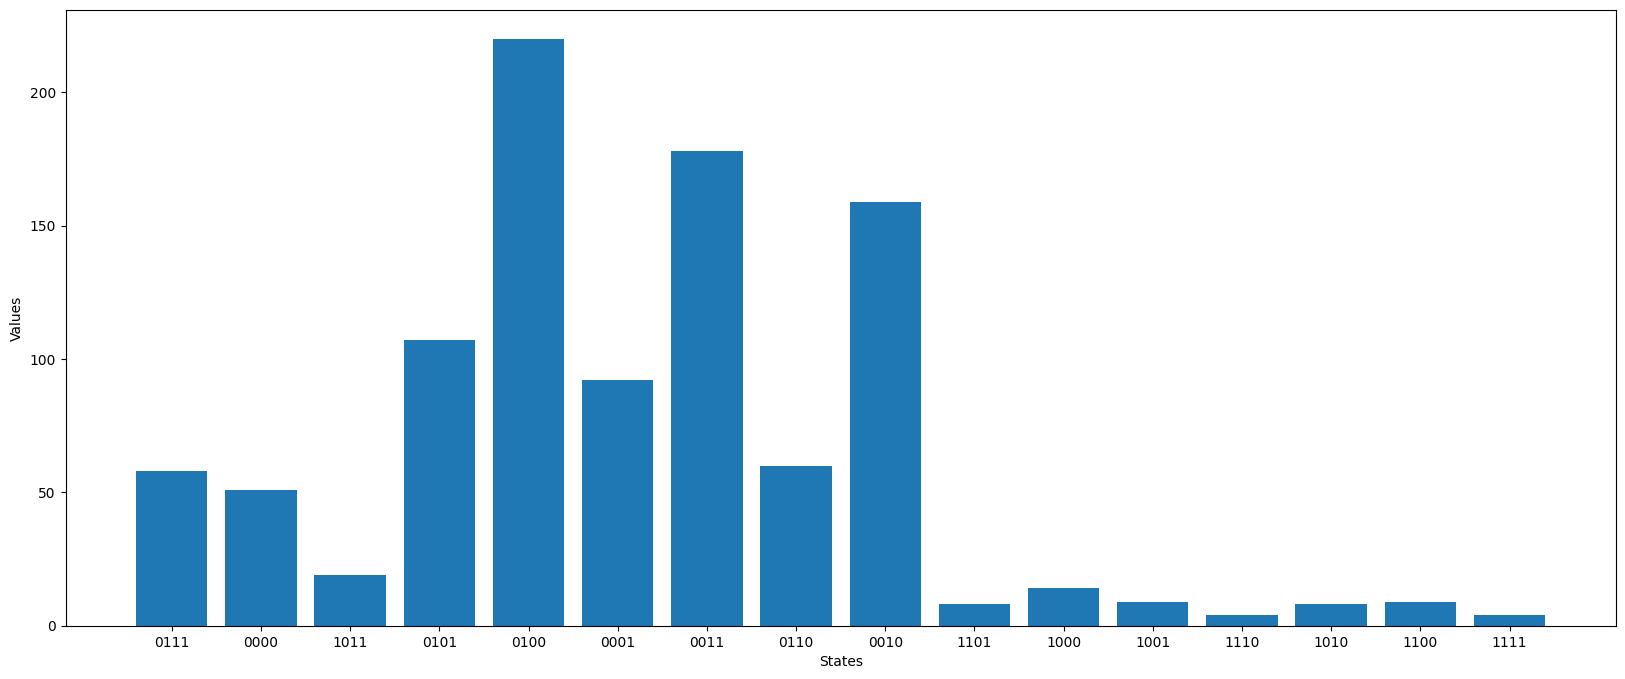

<span style="color:red">>>> Results for job ID: cwhwybhmptp0008k561g</span>

In [6]:

# Plot the results
 
from matplotlib import pyplot as plt

# plotting graph of values

plt.rcParams["figure.figsize"] = (20,8)
plt.bar(counts.keys(), counts.values())
plt.xlabel('States')
plt.ylabel('Values')

plt.show()

display(Markdown('<span style="color:red">>>> Results for job ID: ' + job_id + '</span>'))